# RNetwork Training

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import torch
import numpy as np

from tqdm import tqdm
from omegaconf import OmegaConf

import envs
import utils

from rnet.model import RNetModel
from rnet.memory import RNetMemory
from rnet.dataset import RNetPairsSplitDataset
from exploration_buffer import ExplorationBuffer
from rnet.utils import *

from matplotlib import colors
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Config Utils

In [3]:
cfg_path = f"../conf/config.yaml"

env_name = 'maze_U4rooms'

cfg = OmegaConf.load(cfg_path)
env_cfg = OmegaConf.load(f'../conf/env/{env_name}.yaml')

cfg = OmegaConf.merge(cfg, env_cfg)

space_info = utils.get_space_info(cfg.env.obs, cfg.env.action_dim)
device = torch.device("cuda:1")

In [4]:
env = envs.make_env(cfg.env, space_info)

points = env.generate_points(30, random=False)

## RNet dataset

In [5]:
cfg.exploration_buffer.data_dir = "/checkpoint/linamezghani/offline-gcrl/data/maze_U4rooms-rsp/random/"

In [6]:
cfg.rnet.dataset.thresh = 5
cfg.rnet.dataset.symmetric = False

expl_buffer = ExplorationBuffer(cfg.exploration_buffer)

dataset = RNetPairsSplitDataset(cfg.rnet.dataset, expl_buffer)

## Train RNet

In [7]:
cfg.rnet.model.remove_velocity = True

model = RNetModel(cfg.rnet.model, space_info)
model = model.to(device)

print(model)

RNetModel(
  (encoder): FeatureEncoder(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=16, bias=True)
    )
  )
  (comparator): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [8]:
model.train()
model.to(device)

cfg.rnet.train.num_epochs = 1

stats = train(cfg.rnet.train, model, dataset, device)

rnet epoch 0 - train loss 0.29,  acc 0.91 - val loss 0.14,  acc 0.96


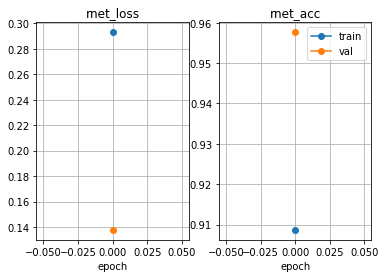

In [9]:
epochs = list(stats.keys())

new_stats = {}
for epoch in epochs:
    for phase in stats[epoch]:
        if not phase in new_stats:
            new_stats[phase] = {}
        for stat, v in stats[epoch][phase].items():
            if not stat in new_stats[phase]:
                new_stats[phase][stat] = []
            if isinstance(v, torch.Tensor):
                v = v.item()
            new_stats[phase][stat].append(v)

fig, ax = plt.subplots(1, 2)
i = 0
for stat in ['rnet_loss', 'rnet_acc']:
    for phase in ['train', 'val']:
        ax[i].plot(epochs, new_stats[phase][stat], label=phase, marker='o')
    ax[i].grid()
    ax[i].set_title(stat)
    ax[i].set_xlabel('epoch')
    i += 1
ax[1].legend()
plt.show()

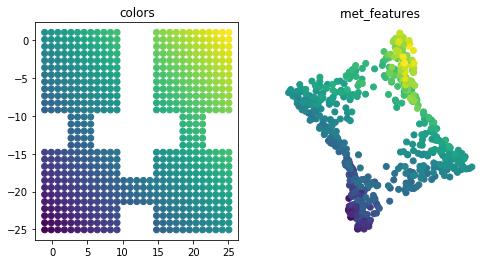

In [10]:
model.eval()
model.to("cpu")
fig = env.plot_embeddings(model, points['state'][:, :], points['state'][:, :],
                          show_colors=True)

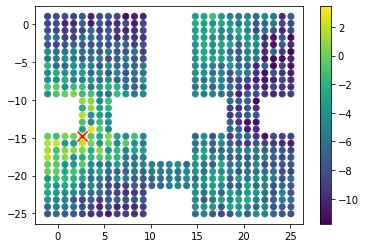

In [11]:
i = np.random.randint(0, points['state'][:, :3].shape[0])
fig = env.plot_values(
    model,
    points['state'][:, :3][i],
    points['state'][:, :3][i],
    points['state'][:, :3],
    points['state'][:, :3]
)

In [12]:
model.to(device)
embs = embed_expl_buffer(expl_buffer, model, device)
expl_buffer.set_embs(embs.to(device))



embed exploration buffer: 100%|██████████| 10000/10000 [00:08<00:00, 1159.93it/s]


## Build Memory

In [13]:
cfg.rnet.memory.skip = 0.0001
cfg.rnet.memory.capacity = 1000
cfg.rnet.memory.directed = True

In [14]:
memory = RNetMemory(cfg.rnet.memory, space_info, model.feat_size, device)

model = model.to(device)
memory = build_memory(cfg.rnet.memory, space_info, model, expl_buffer, device)
memory.compute_dist()

Updating Memory:  30%|██▉       | 2962/10000 [00:50<02:01, 57.80it/s]

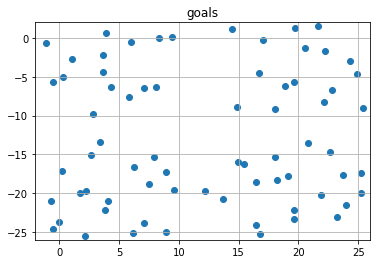

In [ ]:
env.set_goals(memory.get_goals())
fig = env.plot_goals()

In [ ]:
NN = compute_NN(expl_buffer.embs, model, memory, device)

computing NN: 100%|██████████| 10000/10000 [00:09<00:00, 1025.76it/s]


In [ ]:
memory = compute_edges(memory, NN, model)

computing edges: 100%|██████████| 10000/10000 [00:09<00:00, 1062.79it/s]


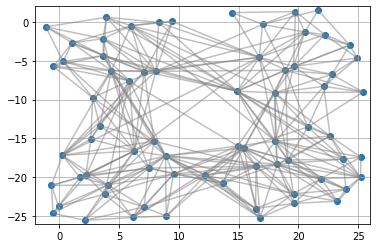

In [ ]:
fig = env.plot_graph(memory)

In [ ]:
memory.adj_matrix.sum()

0

ValueError: 'c' argument has 1000 elements, which is not acceptable for use with 'x' with size 70, 'y' with size 70.

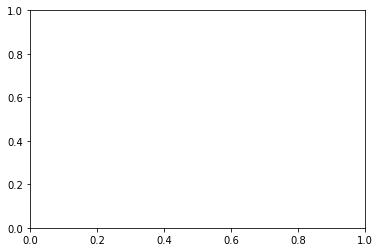

In [ ]:
fig = env.plot_graph_dist(memory)

## Save

In [286]:
exp_name = 'walker_thresh2-velo'
save_dir = os.path.join('/checkpoint/linamezghani/offline-gcrl/rnet/', exp_name)

save(save_dir, model, memory, NN)

Saving rnet objects to  /checkpoint/linamezghani/offline-gcrl/rnet/walker_thresh2-velo


In [46]:
avg_distance = 0

for i in tqdm(range(expl_buffer.states.shape[0])):
    for j in range(expl_buffer.states.shape[1]):
        NN_state = memory.states[NN["outgoing"][i, j]]
        avg_distance += np.linalg.norm(NN_state[:2] - expl_buffer.states[i, j, :2])
        
avg_distance /= (expl_buffer.states.shape[0] * expl_buffer.states.shape[1])
print(f"Average distance from state to its NN: {avg_distance:.2f}")

100%|██████████| 10000/10000 [01:13<00:00, 136.21it/s]

Average distance from state to its NN: 1.35


In [312]:
N = 100


traj = expl_buffer.states[:N].reshape((-1, expl_buffer.states.shape[-1]))
flat_NN = NN[:N].flatten()
classes = np.unique(flat_NN)
np.random.shuffle(classes)
c = [np.where(flat_NN[j] == classes)[0][0] for j in range(len(traj))]

cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.arange(0, len(classes), 1), cmap.N)

sc = plt.scatter(traj[:, 0], traj[:, 1], c=c, cmap=cmap, norm=norm, edgecolor='none')
plt.colorbar(sc)
plt.xlim(env.xlim)
plt.ylim(env.ylim)
plt.show()

NameError: name 'NN' is not defined